# Spam Detector - NLP Assignment

In [1]:
import nltk
import nltk.corpus as corpus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from nltk.metrics import ConfusionMatrix
import time

seed = 42

## Data Loading

In [2]:
path = "dataset/emails.csv"

dataset = pd.read_csv(path)

print('Dataset Size:', dataset.shape)

print("Index Column",dataset.columns[0])

print("Label Column",dataset.columns[-1])

X = dataset.drop([dataset.columns[0],dataset.columns[-1]],axis=1)
Y = dataset[dataset.columns[-1]]

Dataset Size: (5172, 3002)
Index Column Email No.
Label Column Prediction


## Preoprocessing

The dataset has been splitted in two components: **Train Set** and **Test Set**.
The train set will be used for the training the model, while the test set, only to measure the 
efficancy of the model.

I applied **shuffling** to the split to avoid ordered bias on data, and **stratification** 
so that the train and test set have the same ratio of spam and non spam emails, 
improving the vailidity of the results.

In [3]:
np.random.seed(seed)
from sklearn.model_selection import train_test_split

def dataset_split(dataset: pd.DataFrame,train_size:float|None) -> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    D = dataset[dataset.columns.drop('Email No.')]
    X = D[D.columns.drop('Prediction')]
    Y = D['Prediction']#.apply(lambda x: 'no-spam' if x == 0 else 'spam')
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=train_size,shuffle=True,stratify=Y)
    return X_train,X_test,Y_train,Y_test

train_size = 0.8

X_train,X_test,Y_train,Y_test = dataset_split(dataset=dataset,train_size=train_size)

print('Data Train Size',X_train.shape)
print('Data Test Size',X_test.shape)
print('Label Train Size',Y_train.shape)
print('Label Test Size',Y_test.shape)

Data Train Size (4137, 3000)
Data Test Size (1035, 3000)
Label Train Size (4137,)
Label Test Size (1035,)


### Stopword Dataset

I created a different dataset from the original, where I removed all the 
**english stopwords**, this to test if the there is a kind of improvement, 
to the performance, even if it is unaspected to the Naive Bayes Model.

In [4]:
stopwords = corpus.stopwords.words('english')
print("Stopwords: ",len(stopwords))
print(stopwords[:5])
inside_stopwords = X_train.columns.difference(stopwords)
X_train_stop = X_train[inside_stopwords]
X_test_stop = X_test[inside_stopwords]
print("Features: ",len(X_train_stop.columns))

Stopwords:  179
['i', 'me', 'my', 'myself', 'we']
Features:  2866


### Mutual Information Dataset

Another variation of the dataset is to remove all the words that do not bring enough 
information to the classification of the train set.

The **Mutual Information** between the single features and the labels, with the following formula:
$$
    I(\text{word},\textbf{labels}) = p(\text{word},\text{spam}) \log\left(\frac{p(\text{word},\text{spam})}{p(\text{word})p(\text{spam})}\right) +  
    p(\text{word},\text{nospam}) \log\left(\frac{p(\text{word},\text{nospam})}{p(\text{word})p(\text{nospam})}\right)
$$

After retrieving all the information value for each featuere, i discard those below a fixed threshold.

In [5]:
from sklearn.feature_selection import mutual_info_classif

mi_threshold = 0.01
mi = mutual_info_classif(X_train,Y_train)

#Vector of mutual information with index = word feature 
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

#Select the feature which have mutual information highter than the threshold

selected_words = mi_series[mi_series>mi_threshold].index

X_train_mi = X_train[selected_words]
X_test_mi = X_test[selected_words]
print("Features: ",len(X_train_mi.columns))

Features:  670


## Naive Bayes Text Classifier

In [6]:
from nltk.classify import NaiveBayesClassifier
from nltk.probability import LidstoneProbDist
from nltk.metrics import ConfusionMatrix

np.random.seed(seed)

The **NLTK** library use a different data structures for input insted of matrix or dataframe.
It use the a list of dictonaries to performe training, predicting and metrics calculation.
Therefore i created some function that cast dataframe to list of dict.

In [7]:
def make_labeled_featureset(X:pd.DataFrame,Y: pd.DataFrame) -> list:
    labeled_featuresets = [
        (row[1].to_dict(), str(label)) 
        for row, label in zip(X.iterrows(), Y)
    ]
    return labeled_featuresets

def make_featureset(X: pd.DataFrame) -> list:
    featuresets = [
        row[1].to_dict() 
        for row in X.iterrows()
    ]
    return featuresets

def make_label_list(Y: pd.DataFrame) -> list:
    return [str(label) for label in Y]

### Model
The **Naive Bayes Model** classify the data using the bayes formula, the parameters are estimated in this way:
$$
    p(\text{label}) = \frac{count(\text{label})}{count(\text{allLabels})} \\ \\
    p(\text{word}|\text{label}) = \frac{count(\text{word},\text{label}) + \gamma}{count(\text{word},\text{allLabels}) + \gamma |V|}
$$
Where $V$ is the number of total words used for the training.
In this case the parameter $\mathbf{\gamma}$ can be tuned for better performance.

But the current implementation of the class `NaiveBayesClassifier` do not allows 
edit to this parameter, it take as estimator a particular instance of the above formula
(`LidstoneProbDist` object) with $\gamma=0.5$,
in this case i override the estimator using a function that return an estimator that have
fixed gamma parameter of our choise. 

In [26]:
def train_NBC(X_train:pd.DataFrame,Y_train: pd.DataFrame,gamma:float) -> NaiveBayesClassifier:
    XY_train = make_labeled_featureset(X_train,Y_train)
    #override of the estimator with gamma of our choise
    prob_estimator = lambda freqdist, bins=None : LidstoneProbDist(freqdist,gamma,bins)
    nbc = NaiveBayesClassifier.train(XY_train,estimator=prob_estimator)
    return nbc

In [27]:
def classify_NBC(X_test:pd.DataFrame,nbc:NaiveBayesClassifier) -> list:
    X_test = make_featureset(X_test)
    return nbc.classify_many(X_test)

### Cross Validation e Fine Tuning

To tune the model on the best $\gamma$ parameter, I use the the **K-Fold Cross Validation** method, 
which mean that the training set will be splitted in $k$ segments, and the model will be trained 
$k$ times on the $k-1$ segments, and the $k$th will be used as test set.

For the evaluation will be used the mean **f1-score** of all $k$ execution, for each $\gamma$ in input.

In [28]:
from sklearn.model_selection import StratifiedKFold

def cross_validation_fine_tuning(X_train:pd.DataFrame,Y_train:pd.DataFrame,Gammas,n_split:int,verbose:bool=False) -> dict:

    list_measures = {gamma: [] for gamma in Gammas}
    mean_measures = {}

    if n_split > 1:
        for gamma in Gammas:
            skf = StratifiedKFold(n_splits=n_split,shuffle=True)
            skf.get_n_splits(X_train,Y_train)
            k_folds = skf.split(X_train,Y_train)
            # k_fold containt a list of indexes that will rappresent the kth-fold for test, 
            # and the others will be use for training.
            for j,(train_index, val_index) in enumerate(k_folds):
                X_train_k = X_train.iloc[train_index]
                Y_train_k = Y_train.iloc[train_index]
                X_val_k = X_train.iloc[val_index]
                Y_val_k = Y_train.iloc[val_index]

                nbc = train_NBC(X_train_k,Y_train_k,gamma)
                Y_pred = classify_NBC(X_val_k,nbc)
                Y_pred = [int(label) for label in Y_pred]
                score = f1_score(Y_pred,Y_val_k)
                if (verbose):
                    print(f"Gamma {gamma} on {j}-fold: {score}")
                list_measures[gamma].append(score)

            mean_measures[gamma] = np.mean(list_measures[gamma])

    else:
        X_train_k, X_val_k,Y_train_k,Y_val_k = train_test_split(X_train,Y_train,shuffle=True,stratify=Y_train,train_size=0.9)
        for gamma in Gammas:
            nbc = train_NBC(X_train_k,Y_train_k,gamma)
            Y_pred = classify_NBC(X_val_k,nbc)
            Y_pred = [int(label) for label in Y_pred]
            score = f1_score(Y_pred,Y_val_k)
            list_measures[gamma].append(score)
            mean_measures[gamma] = np.mean(list_measures[gamma])

    return mean_measures

In [29]:
#simply retrive the gamma assosieted with the highest mean f1 score on the k executions
def get_best_gamma(eval_measures:dict) -> int:
    best_gamma = max(eval_measures,key=eval_measures.get)
    print("Best Gamma: ",best_gamma)
    print("Mean F1: ",eval_measures[best_gamma])
    return best_gamma

### Evaluation

For the final evaluation after choose the best $\gamma$, will be used 
the **Confusion Matrix** of NLTK. 

In [30]:
def eval_model(X_test:pd.DataFrame,Y_test:pd.DataFrame,nbc:NaiveBayesClassifier) -> ConfusionMatrix:
    Y_test = make_label_list(Y_test)
    Y_pred = classify_NBC(X_test,nbc)
    return ConfusionMatrix(Y_pred,Y_test)

### Gamma Parameters

Usually the parameter $\gamma$ range from $0$ to $1$, after a first search
in that range, I locateted that the best parameter is **lower** than $0.25$,
so i performed a fine tuning of $\gamma$ in range $(0,0.25)$.

In [31]:
Gammas = [0,0.05,0.10,0.15,0.20,0.25]

### Complete Dataset

In [32]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_complete = train_NBC(X_train,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_complete = eval_model(X_test,Y_test,nbc_complete)
end_predict = time.time()

print(cs_complete.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  202.77839255332947  seconds
Best Gamma:  0.05
Mean F1:  0.802905374411449
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.8990 | 0.9210
  1 | 0.7400 | 0.8441 | 0.7886

Training Time:  5.747609376907349  seconds
Classification Time:  2.6166563034057617  seconds


### Stopwords Dataset

In [33]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train_stop,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_stop = train_NBC(X_train_stop,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_stop = eval_model(X_test_stop,Y_test,nbc_stop)
end_predict = time.time()

print(cs_stop.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  195.52402806282043  seconds
Best Gamma:  0.05
Mean F1:  0.8026579917887823
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.8978 | 0.9204
  1 | 0.7367 | 0.8435 | 0.7865

Training Time:  5.916151285171509  seconds
Classification Time:  2.799798011779785  seconds


### Dataset with Mutual Information

In [34]:
start_cv = time.time()
mean_f1_scores = cross_validation_fine_tuning(X_train_mi,Y_train,Gammas,n_split=5)
end_cv = time.time()

print("Cross Validation Time: ",end_cv-start_cv," seconds")

best_gamma = get_best_gamma(mean_f1_scores)

start_train = time.time()  
nbc_mi = train_NBC(X_train_mi,Y_train,best_gamma)
end_train = time.time()  

start_predict = time.time()
cs_mi = eval_model(X_test_mi,Y_test,nbc_mi)
end_predict = time.time()

print(cs_mi.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Cross Validation Time:  44.99998927116394  seconds
Best Gamma:  0.05
Mean F1:  0.8267710652323135
Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9442 | 0.9144 | 0.9290
  1 | 0.7833 | 0.8514 | 0.8160

Training Time:  1.272050380706787  seconds
Classification Time:  0.6166384220123291  seconds


### Summary
Apparently the best gamma for all the dataset is $\gamma=0.05$ 
and the dataset reduced using **mutual information selection**, perform better in classification.
We can also observe, what words weigth more in the classification procedure.

In [37]:
print("Dataset Complete:")
nbc_complete.show_most_informative_features()
print("Dataset StopWord:")
nbc_stop.show_most_informative_features()
print("Dataset Mutual Information:")
nbc_mi.show_most_informative_features()

Dataset Complete:
Most Informative Features
               forwarded = 1                   0 : 1      =    214.9 : 1.0
                     sex = 1                   1 : 0      =    167.9 : 1.0
                     biz = 1                   1 : 0      =    116.6 : 1.0
                      rx = 1                   1 : 0      =    112.0 : 1.0
                     hpl = 1                   0 : 1      =    109.0 : 1.0
                    spam = 1                   1 : 0      =    100.3 : 1.0
                  weight = 1                   1 : 0      =     98.0 : 1.0
                     iit = 1                   1 : 0      =     88.7 : 1.0
                   cheap = 1                   1 : 0      =     81.2 : 1.0
                   sleep = 1                   1 : 0      =     79.4 : 1.0
Dataset StopWord:
Most Informative Features
               forwarded = 1                   0 : 1      =    214.9 : 1.0
                     sex = 1                   1 : 0      =    167.9 : 1.0
            

In this case the most relevant words are `forwarded`, `sex` and `biz`, in particular 
-  `forwarded` is associeted to **non-spam** email with a ratio 215 to 1
-  `sex` is associeted to **spam** email with a ratio 168 to 1
-  `biz` is associeted to **spam** email with a ratio 116 to 1

Also these words, have more weigth in the mutual information dataset, since most of the 
other words, are been excludeted since they bring low information.
This dataset perform better and it significantly fasten the train and prediction of the model.

## Multi-layer Perceptrone - 2 Layers

Naive Bayes model, assumes that there is indipendence between the words, 
it is a bit unlikely, even if the result reached are good, we can do better.

The next model i want to try is the **MLP with 2 layers**, which is a fully-connected neural network.

### Cross Validation e Fine Tuning

The model is initialized with the following fixed parameters:
- `adam`: which is the solver that performs the gradient descent for parameters optimization
- `shuffle`: which shuffles the samples at each epoch before dividing them into batches 
- `early_stopping`: which interrupts the training loop if there is not any improvement over the evaluation of the trained model on the validation set.
- `relu`: the activation function that will be used between the layers which is difined by:
$$
\text{ReLU}(x)= \begin{cases} 
                    x & \text{if } x > 0 \\ 
                    0 & \text{if } x \leq 0 
                \end{cases}
$$

While the tuning will be performed on the following parameters:
- `alpha`: which is the regularization parameter used with the loss function in order to smooth the 
optimization done by adam
- `hidden_layer_sizes`: it is possible for a small model to do not capture the pattern of the dataset, while a large model can easly overfit for this kind of task

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier


np.random.seed(seed)

param_grid = {
    'hidden_layer_sizes': [(70,70),(80,80),(90,90)],
    'activation' : ['relu'],
    'solver': ['adam'],
    'alpha': [1e-5,1e-6,1e-7],
    'shuffle': [True],
    'early_stopping': [True]
}

# grid search cv will perform stratified k-fold crossvalidation for each 
# combination of parameter indicated in param_grid, than wil select the best model 
# using the mean f1-score of the k trainings.
best_mlpc_model = GridSearchCV(MLPClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))
best_mlpc_model.fit(X_train_mi,Y_train)

print(best_mlpc_model.best_params_)

{'activation': 'relu', 'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (80, 80), 'shuffle': True, 'solver': 'adam'}


### Build-In Model with NLTK

It is possible to use classification model of sklearn in combination with **NLTK**, so that 
we can match the dictionary input of NLTK models with the arraylike input of sklearn.

In [19]:
from nltk.classify import SklearnClassifier

clf = SklearnClassifier(best_mlpc_model)

train_labeled_featuresets = make_labeled_featureset(X_train,Y_train)
test_featuresets = make_featureset(X_test)
test_labels = make_label_list(Y_test)

start_train = time.time()
clf.train(train_labeled_featuresets)
end_train = time.time()

start_predict = time.time()
pred_labels = clf.classify_many(test_featuresets)
end_predict = time.time()

cs = ConfusionMatrix(pred_labels,test_labels)
print(cs.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.9864 | 0.9959 | 0.9911
  1 | 0.9900 | 0.9674 | 0.9786

Training Time:  559.3927063941956  seconds
Classification Time:  1.1136808395385742  seconds


### Mutual Information Dataset

In [ ]:
from nltk.classify import SklearnClassifier

clf = SklearnClassifier(best_mlpc_model)

train_labeled_featuresets = make_labeled_featureset(X_train_mi,Y_train)
test_featuresets = make_featureset(X_test_mi)
test_labels = make_label_list(Y_test)

start_train = time.time()
clf.train(train_labeled_featuresets)
end_train = time.time()

start_predict = time.time()
pred_labels = clf.classify_many(test_featuresets)
end_predict = time.time()

cs = ConfusionMatrix(pred_labels,test_labels)
print(cs.evaluate())
print("Training Time: ",end_train-start_train," seconds")
print("Classification Time: ",end_predict-start_predict," seconds")

## Provenance

In [4]:
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

np.random.seed(seed)

dimention = 2

colors = ['green' if label == 0 else 'orange' for label in Y_train]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled.shape)

(4137, 3000)


In [90]:
def plot_components(X,colors):
    plt.scatter(X[:, 0], X[:, 1],c=colors,s=15)
    plt.show()

In [ ]:
np.random.seed(seed)
tsne = TSNE(n_components=dimention)

X_train_tsne = tsne.fit_transform(X_train_scaled)

plot_components(X_train_tsne,colors)

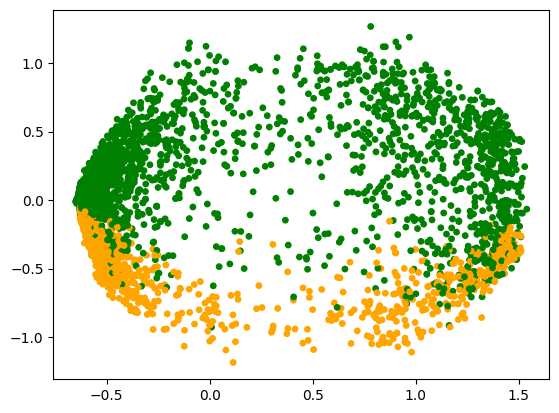

In [92]:
kpca = KernelPCA(n_components=dimention,kernel='sigmoid',gamma=1)

X_train_kpca = kpca.fit_transform(X_train_scaled)

plot_components(X_train_kpca,colors)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

np.random.seed(seed)

param_grid = {
    'n_neighbors' : np.arange(1,100,2),
    'weights':['uniform','distance'],
    'metric': ['euclidean','haversine','manhattan']
}
 
best_knn_model = GridSearchCV(KNeighborsClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))

best_knn_model.fit(X_train_kpca,Y_train)

print(best_knn_model.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'metric': 'euclidean', 'n_neighbors': np.int64(77), 'weights': 'distance'}


In [16]:
X_test_kpca = kpca.transform(scaler.transform(X_test))
Y_pred = best_knn_model.predict(X_test_kpca)
print(f1_score(Y_test,Y_pred))

0.9030303030303031


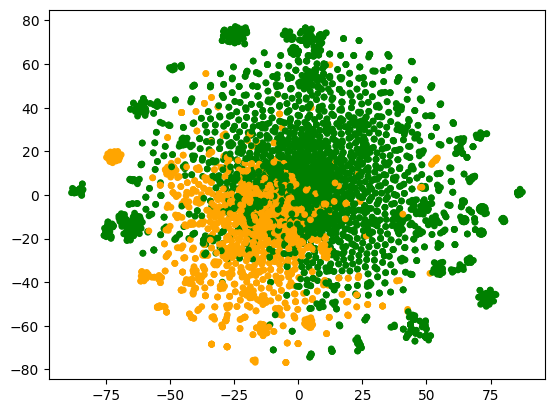

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(seed)
tsne = TSNE(n_components=dimention)

X_tsne = tsne.fit_transform(scaler.fit_transform(X))

plot_components(X_tsne,['green' if label == 0 else 'orange' for label in Y])

X_train_tsne, X_test_tsne, Y_train_tsne , Y_test_tsne = train_test_split(X_tsne,Y,train_size=train_size,shuffle=True,stratify=Y)


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

np.random.seed(seed)

param_grid = {
    'n_neighbors' : np.arange(1,100,2),
    'weights':['uniform','distance'],
    'metric': ['euclidean','haversine','manhattan']
}
 
best_knn_model = GridSearchCV(KNeighborsClassifier(),param_grid,scoring='f1',cv=StratifiedKFold(shuffle=True))

best_knn_model.fit(X_train_tsne,Y_train_tsne)

print(best_knn_model.best_params_)

{'metric': 'manhattan', 'n_neighbors': np.int64(11), 'weights': 'distance'}


In [27]:
np.random.seed(seed)
#X_test_tsne = tsne.fit_transform(scaler.transform(X_train_tsne))
Y_pred = best_knn_model.predict(X_test_tsne)
print(f1_score(Y_test_tsne,Y_pred))

0.8838709677419355


In [111]:
from sklearn.model_selection import train_test_split
np.random.seed(seed)
kpca = KernelPCA(n_components=3,kernel='sigmoid')

X_kpca = kpca.fit_transform(scaler.fit_transform(X))

X_train_tsne, X_test_tsne, Y_train_tsne , Y_test_tsne = train_test_split(X_kpca,Y,train_size=train_size,shuffle=True,stratify=Y)

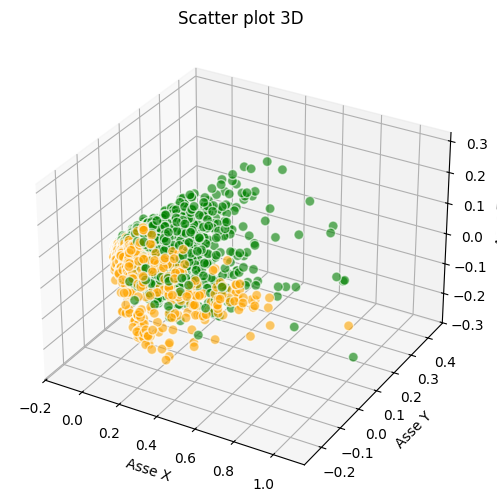

In [112]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plottaggio dei punti
ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=['green' if label == 0 else 'orange' for label in Y], s=50, alpha=0.6, edgecolors='w')

# Etichette degli assi
ax.set_xlabel('Asse X')
ax.set_ylabel('Asse Y')
ax.set_zlabel('Asse Z')

# Titolo
ax.set_title('Scatter plot 3D')

# Mostra il grafico
plt.show()

In [ ]:
from sklearn.cluster import HDBSCAN

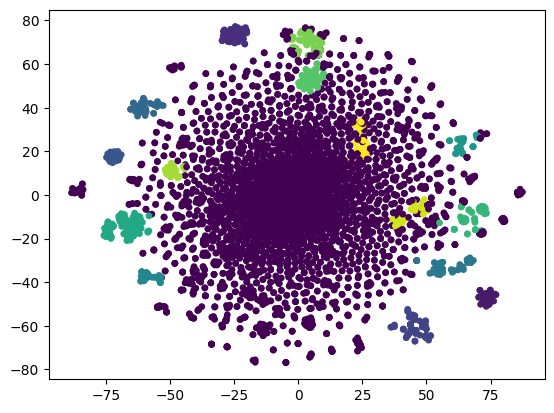

In [104]:
hdbscan = HDBSCAN(min_cluster_size=30,max_cluster_size=200)

clusters = hdbscan.fit_predict(X_tsne)

plot_components(X_tsne,clusters)

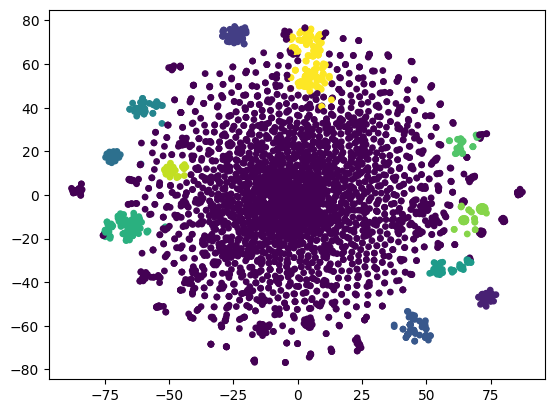

In [100]:
hdbscan = HDBSCAN(min_cluster_size=30,max_cluster_size=200)

clusters = hdbscan.fit_predict(X_train_tsne)

plot_components(X_train_tsne,clusters)

In [101]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
silhouette_avg = silhouette_score(X_train_tsne, clusters)
davies_bouldin = davies_bouldin_score(X_train_tsne, clusters)

print(f"Silhouette Score (KMeans): {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index (KMeans): {davies_bouldin:.2f}")


Silhouette Score (KMeans): -0.08
Davies-Bouldin Index (KMeans): 0.61
